# Modelling

In [1]:
cd ..

/mnt/d/Projekty/spotify-recommender-system


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import cross_val_score, KFold

from hyperopt import hp, tpe, fmin, space_eval, Trials, STATUS_OK

import warnings

SEED = 11
warnings.filterwarnings('ignore')

In [3]:
df_train = pd.read_pickle('./data/processed/songs_train.pkl')
df_train.head()

,acousticness,danceability,energy,if_liked,instrumentalness,liveness,loudness,mode,speechiness,tempo,...,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_3,time_signature_4,time_signature_5
Shame Of Device,0.000336,0.652,0.638,1,0.9450,0.0839,0.380867,1,0.0277,0.758141,...,0,0,1,0,0,0,0,0,1,0
Annie,0.003700,0.603,0.504,0,0.0383,0.1040,-0.003722,1,0.0289,-0.008774,...,0,1,0,0,0,0,0,0,1,0
The Crown and the Ring (Lament of the Kings),0.492000,0.228,0.130,0,0.0000,0.1840,-1.726194,0,0.0326,-1.160017,...,0,0,0,0,0,0,0,1,0,0
I'm On Fire,0.589000,0.620,0.446,0,0.0299,0.0727,-1.660753,0,0.0347,-1.423080,...,0,0,0,0,0,0,0,0,1,0
March of the Forest Cat,0.429000,0.864,0.582,1,0.9010,0.0998,-0.642018,1,0.1990,0.080243,...,0,0,0,1,0,0,0,0,1,0


In [4]:
X_train, y_train = df_train.drop(['if_liked'], axis=1), df_train['if_liked']

In [5]:
def objective(params):    
    classifier_name = params['classifier']
    del params['classifier']
    
    if classifier_name == 'lr':
        clf = LogisticRegression(**params,
                                 random_state=SEED)
    elif classifier_name == 'rf':
        clf = RandomForestClassifier(**params,
                                     oob_score=True,
                                     random_state=SEED)
    elif classifier_name == 'xgb':
        clf = XGBClassifier(**params,
                            eval_metric='logloss',
                            use_label_encoder=False,
                            random_state=SEED)
    else:
        print('Wrong classifier!')
        return
    
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
    loss = 1 - max(scores)
    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

## Logistic Regression
Hyperparameters to be tuned:
- **C** &ndash; regularization parameter controlling a trade-off between underfitting and overfitting of the model
- **warm_start** &ndash; parameter declaring usage of previous solution as an initialization for the following fit
- **fit_intercept** &ndash; specifies if the constant is added to the function
- **max_iter** &ndash; maximum number of iteration for the algorithm to converge
- **solver** &ndash; algorithm used for problem optimization

In [6]:
lr_params = {'classifier': 'lr',
             'C': hp.uniform('C', 0, 20),
             'warm_start': hp.choice('warm_start', [True, False]),
             'fit_intercept': hp.choice('fit_intercept', [True, False]),
             'max_iter': hp.choice('max_iter', range(5, 1000)),
             'solver': hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])}

In [7]:
bayes_trials = Trials()
best = fmin(fn=objective, space=lr_params, algo=tpe.suggest, max_evals=50, trials=bayes_trials)
best = space_eval(lr_params, bayes_trials.argmin)
best

100%|██████████| 50/50 [00:18<00:00,  2.64trial/s, best loss: 0.21577726218097437]


{'C': 0.12590803224234115,
 'classifier': 'lr',
 'fit_intercept': False,
 'max_iter': 67,
 'solver': 'liblinear',
 'warm_start': True}

In [8]:
lr_tuned = LogisticRegression(C=best['C'],
                              solver=best['solver'],
                              max_iter=best['max_iter'],
                              fit_intercept=best['fit_intercept'],
                              warm_start=best['warm_start'],
                              random_state=SEED)

## Random Forest
Hyperparameters to be tuned:
- **criterion** &ndash; a function measuring the quality of a split, *gini* uses the Gini impurity while *entropy* makes the split based on information gain
- **n_estimators** &ndash; number of decision trees in the ensemble model
- **max_depth** &ndash; specifies the maximum depth of decision trees, the deeper a tree, the more complex a model will become
- **min_samples_split** &ndash; the minimum number of samples required to split an internal node
- **min_samples_leaf** &ndash; the minimum number of samples required to be at a leaf node

In [9]:
rf_params = {'classifier': 'rf',
             'criterion': hp.choice('criterion', ['gini', 'entropy']),
             'n_estimators': hp.choice('n_estimators', range(100, 2100, 100)),
             'max_depth': hp.choice('max_depth', range(5, 16)),
             'min_samples_split': hp.choice('min_samples_split', range(5, 11)),
             'min_samples_leaf': hp.choice('min_samples_leaf', range(3, 6))}

In [10]:
bayes_trials = Trials()
best = fmin(fn=objective, space=rf_params, algo=tpe.suggest, max_evals=50, trials=bayes_trials)
best = space_eval(rf_params, bayes_trials.argmin)
best

100%|██████████| 50/50 [10:09<00:00, 12.20s/trial, best loss: 0.19506172839506175]


{'classifier': 'rf',
 'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 700}

In [11]:
rf_tuned = RandomForestClassifier(criterion=best['criterion'],
                                  max_depth=best['max_depth'],
                                  min_samples_leaf=best['min_samples_leaf'],
                                  min_samples_split=best['min_samples_split'],
                                  n_estimators=best['n_estimators'],
                                  oob_score=True,
                                  random_state=SEED)

## Extreme Gradient Boosting
Hyperparameters to be tuned:
- **learning_rate** &ndash; specifies the shrinkage of the feature weights made in every training step
- **n_estimators** &ndash; number of decision trees in the ensemble model
- **gamma** &ndash; the minimum loss reduction required to make a further partition on a leaf node of the tree
- **max_depth** &ndash; specifies the maximum depth of decision trees, the deeper a tree, the more complex a model will become
- **min_child_weight** &ndash; the minimum sum of instance weight needed in a child
- **subsample** &ndash; subsample ratio of the training instances, it prevents overfitting of a model

In [12]:
xgb_params = {'classifier': 'xgb',
              'learning_rate': hp.uniform('learning_rate', 0, 0.5),
              'n_estimators': hp.choice('n_estimators', range(100, 2100, 100)),
              'gamma': hp.choice('gamma', range(0, 6)),
              'max_depth': hp.choice('max_depth', range(5, 16)),
              'min_child_weight': hp.choice('min_child_weight', range(1, 6)),
              'subsample': hp.uniform('subsample', 0.5, 1)}

In [13]:
bayes_trials = Trials()
best = fmin(fn=objective, space=xgb_params, algo=tpe.suggest, max_evals=50, trials=bayes_trials)
best = space_eval(xgb_params, bayes_trials.argmin)
best

100%|██████████| 50/50 [07:14<00:00,  8.69s/trial, best loss: 0.1959798994974874]


{'classifier': 'xgb',
 'gamma': 5,
 'learning_rate': 0.12468147655917994,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 800,
 'subsample': 0.6966716089145932}

In [14]:
xgb_tuned = XGBClassifier(gamma=best['gamma'],
                          max_depth=best['max_depth'],
                          n_estimators=best['n_estimators'],
                          min_child_weight=best['min_child_weight'],
                          learning_rate=best['learning_rate'],
                          subsample=best['subsample'],
                          eval_metric='logloss',
                          use_label_encoder=False,
                          random_state=SEED)

## Comparison of algorithms

In [15]:
models = []
models.append(('Logistic Regression', lr_tuned))
models.append(('Random Forest', rf_tuned))
models.append(('XGBoost', xgb_tuned))

results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1') 
    
    results.append(cv_results)
    names.append(name)
    
    print(f"{name}: {cv_results.mean()} ({cv_results.std()})")

Logistic Regression: 0.7567934050774665 (0.041188592439545854)
Random Forest: 0.7861410273451004 (0.03223132839453992)
XGBoost: 0.7749615059774024 (0.02530108997441962)


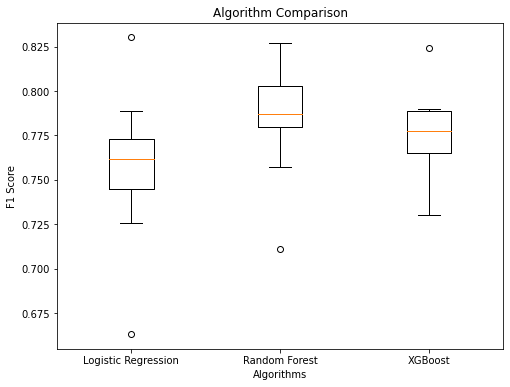

In [16]:
fig = plt.figure(figsize=(8, 6))
plt.boxplot(results)
plt.title('Algorithm Comparison')
plt.xticks([1, 2, 3], names)
plt.ylabel('F1 Score')
plt.xlabel('Algorithms')
plt.show()

Based on the results of algorithms, Random Forest classifier will be chosen as it reaches the highest F1 score and appears to be the most stable.

## Evaluation of chosen classifier

In [17]:
df_test = pd.read_pickle('./data/processed/songs_test.pkl')
X_test, y_test = df_test.drop(['if_liked'], axis=1), df_test['if_liked']

In [18]:
rf_tuned.fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)

accuracy = round(accuracy_score(y_pred, y_test) * 100, 1)
f1 = round(f1_score(y_pred, y_test) * 100, 1)

print(f'Accuracy score on test set: {accuracy} %')
print(f'F1 score on test set: {f1} %')

Accuracy score on test set: 71.8 %
F1 score on test set: 79.1 %
